# Loading Models

In [111]:
from importlib import reload


In [117]:
import chat_gpt_classifier_tasked_2
import conceptnet_classifier_specified_tasked_2

reload(chat_gpt_classifier_tasked_2)
reload(conceptnet_classifier_specified_tasked_2)


<module 'conceptnet_classifier_specified_tasked_2' from '/home/rafaelhidalgo/git_projects/ConceptNet/conceptnet_classifier_specified_tasked_2.py'>

In [105]:
from chat_gpt_classifier_tasked_2 import get_chat_gpt_context
from conceptnet_classifier_specified_tasked_2 import get_conceptnet_context


In [22]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # Example for English model
ft_model = fasttext.load_model('cc.en.300.bin')


 (100.00%) [==================================================>]                                                 ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]> 

In [2]:
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
import gensim.downloader as api
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

# Load pre-trained Word2Vec and GloVe models
word2vec_model = api.load("word2vec-google-news-300")
glove_model = api.load("glove-wiki-gigaword-300")


# Define Objects and Contexts

In [40]:
# Define your object lists and context groups
objects = {
    "Fruits": ['apple', 'orange', 'lemon', 'banana'],
    "Beverages": ['bottle', 'beer', 'juice', 'wine'],
    "Vegetables": ['carrot', 'bell_pepper', 'cucumber', 'broccoli' ],
    "Snacks": ['pretzel', 'popcorn', 'muffin', 'chocolate'],
    "Office Supplies": ['pen', 'adhesive_tape', 'stapler', 'scissors'],
    "Toys": ['ball', 'dice', 'teddy_bear', 'toy' ],
    "Kitchenware": ['bowl', 'knife', 'spoon', 'mug'],
    "Clothing": ['glove', 'belt', 'sock', 'tie'],
    "Personal Items": ['computer_mouse', 'coin', 'calculator', 'mobile_phone', 'remote_control', 'toothpaste', 'aerosol_can'],
    "Miscellaneous": ['box', 'boot', 'towel', 'flower', 'candle', 'bell']
}

context_groups = [
    ["bedroom", "kitchen", "garden", "office"],
    ["playroom", "dining_room", "laundry_room", "living_room"]
]

LOCATIONS = ["kitchen", "office", "playroom", "living_room", "bedroom", "dining_room", "pantry", "garden", "laundry_room", "bathroom"]

# Define Functions

In [34]:
def get_bert_vector(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = bert_model(**inputs)
    # return outputs[0].detach().numpy().mean(axis=1)
    # Ensure the output is 1-D by reshaping
    return outputs[0].detach().numpy().mean(axis=1).reshape(-1)

def get_fasttext_vector(model, word):
    # FastText can handle words directly, no need to check if they exist in the model
    return model.get_word_vector(word)


def get_word2vec_glove_vector(model, word):
    underscore_word = word.replace(" ", "_")
    space_word = word.replace("_", " ")

    if underscore_word in model.key_to_index:
        return model[underscore_word]
    elif space_word in model.key_to_index:
        return model[space_word]
    else:
        parts = underscore_word.split('_')
        if all(part in model.key_to_index for part in parts):
            vectors = [model[part] for part in parts]
            return np.mean(vectors, axis=0)
        else:
            raise ValueError(f"'{word}' is not in the model vocabulary.")

def calculate_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

# Testing Models

In [33]:
# Sample Test Using FASTTEXT

# Example usage
word1 = "onion"
word2 = "vegetable"

try:
    # Get vectors for FastText, Word2Vec, and GloVe
    fasttext_vec1 = get_fasttext_vector(ft_model, word1)
    fasttext_vec2 = get_fasttext_vector(ft_model, word2)
    word2vec_vec1 = get_word2vec_glove_vector(word2vec_model, word1)
    word2vec_vec2 = get_word2vec_glove_vector(word2vec_model, word2)
    glove_vec1 = get_word2vec_glove_vector(glove_model, word1)
    glove_vec2 = get_word2vec_glove_vector(glove_model, word2)

    # Calculate cosine similarity for each model
    fasttext_similarity = calculate_similarity(fasttext_vec1, fasttext_vec2)
    word2vec_similarity = calculate_similarity(word2vec_vec1, word2vec_vec2)
    glove_similarity = calculate_similarity(glove_vec1, glove_vec2)

    # Print individual similarities
    print(f"FastText Similarity: {fasttext_similarity}")
    print(f"Word2Vec Similarity: {word2vec_similarity}")
    print(f"GloVe Similarity: {glove_similarity}")

    # Average the scores
    average_similarity = (fasttext_similarity + word2vec_similarity + glove_similarity) / 3
    print(f"Average Semantic Similarity Score: {average_similarity}")
except ValueError as e:
    print(e)

FastText Similarity: 0.45840609073638916
Word2Vec Similarity: 0.5865840315818787
GloVe Similarity: 0.4593518376350403
Average Semantic Similarity Score: 0.501447319984436


In [29]:
# Sample Test Using BERT

word1 = "up"
word2 = "down"

# Get vectors for each model
bert_vec1 = get_bert_vector(word1)
bert_vec2 = get_bert_vector(word2)

try:
    word2vec_vec1 = get_word2vec_glove_vector(word2vec_model, word1)
    word2vec_vec2 = get_word2vec_glove_vector(word2vec_model, word2)
    glove_vec1 = get_word2vec_glove_vector(glove_model, word1)
    glove_vec2 = get_word2vec_glove_vector(glove_model, word2)

    # Calculate cosine similarity for each model
    bert_similarity = calculate_similarity(bert_vec1, bert_vec2)
    word2vec_similarity = calculate_similarity(word2vec_vec1, word2vec_vec2)
    glove_similarity = calculate_similarity(glove_vec1, glove_vec2)

    # Print individual similarities
    print(f"BERT Similarity: {bert_similarity}")
    print(f"Word2Vec Similarity: {word2vec_similarity}")
    print(f"GloVe Similarity: {glove_similarity}")

    # Average the scores
    average_similarity = (bert_similarity + word2vec_similarity + glove_similarity) / 3
    print(f"Average Semantic Similarity Score: {average_similarity}")
except ValueError as e:
    print(e)


BERT Similarity: 0.8450323939323425
Word2Vec Similarity: 0.6396992802619934
GloVe Similarity: 0.7469208836555481
Average Semantic Similarity Score: 0.7438841859499613


# Get Chat GPT and conceptnet Results

In [35]:
# Using FastText Model

results = []
for category, items in objects.items():
    for object_name in items:
        for group in context_groups:
            chat_gpt_context = get_chat_gpt_context(object_name, group)
            conceptnet_context, conceptnet_path = get_conceptnet_context(object_name, group)

            # Calculate FastText similarity scores for each context
            
            
            fasttext_similarity_chat_gpt = calculate_similarity(get_fasttext_vector(ft_model, object_name), get_fasttext_vector(ft_model, chat_gpt_context))
            word2vec_similarity_chat_gpt = calculate_similarity(get_word2vec_glove_vector(word2vec_model, object_name), get_word2vec_glove_vector(word2vec_model, chat_gpt_context))
            glove_similarity_chat_gpt = calculate_similarity(get_word2vec_glove_vector(glove_model, object_name), get_word2vec_glove_vector(glove_model, chat_gpt_context))

            fasttext_similarity_conceptnet = calculate_similarity(get_fasttext_vector(ft_model, object_name), get_fasttext_vector(ft_model, conceptnet_context))
            word2vec_similarity_conceptnet = calculate_similarity(get_word2vec_glove_vector(word2vec_model, object_name), get_word2vec_glove_vector(word2vec_model, conceptnet_context))
            glove_similarity_conceptnet = calculate_similarity(get_word2vec_glove_vector(glove_model, object_name), get_word2vec_glove_vector(glove_model, conceptnet_context))


            average_similarity_chat_gpt = (fasttext_similarity_chat_gpt + word2vec_similarity_chat_gpt + glove_similarity_chat_gpt) / 3
            average_similarity_conceptnet = (fasttext_similarity_conceptnet + word2vec_similarity_conceptnet + glove_similarity_conceptnet) / 3

            # Store the results
            results.append({
                'object': object_name,
                'category': category,
                'group': group,
                'chat_gpt_context': chat_gpt_context,
                'conceptnet_context': conceptnet_context,
                'conceptnet_path': conceptnet_path,
                'fasttext_similarity_chat_gpt': fasttext_similarity_chat_gpt,
                'word2vec_similarity_chat_gpt': word2vec_similarity_chat_gpt,
                'glove_similarity_chat_gpt': glove_similarity_chat_gpt,
                'average_similarity_chat_gpt': average_similarity_chat_gpt,
                'average_similarity_conceptnet': average_similarity_conceptnet,
                'fasttext_similarity_conceptnet': fasttext_similarity_conceptnet,
                'word2vec_similarity_conceptnet': word2vec_similarity_conceptnet,
                'glove_similarity_conceptnet': glove_similarity_conceptnet
            })

# Process and print results as needed


system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: bedroom, kitchen, garden, office? Please specify only the context as a response.
Execution time for the chatgpt implementation: 0.9980 seconds
The most relevant context for apple is kitchen.
Desired Contexts: ['bedroom', 'kitchen', 'garden', 'office']
Execution time for the robo-csk implementation: 0.0221 seconds
The most relevant context for apple is kitchen.
Path: kitchen (AtLocation) <- food (RelatedTo) -> apple
Average_Weight: 4.76
Degree of Separation: 2
system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: playroom, dining_room, laundry_room, living_room? Please specify only the context as a response.
Execution time for the chatgpt implementation: 0.8410 seconds
The most relevant context for apple is dining_room.
Desired Contexts: ['playroom', 'dining_room', 'laundry_room',

In [5]:
# Using BERT Model 

results = []
for category, items in objects.items():
    for object_name in items:
        for group in context_groups:
            chat_gpt_context = get_chat_gpt_context(object_name, group)
            conceptnet_context, conceptnet_path = get_conceptnet_context(object_name, group)


            # Calculate similarity scores for each context
            # (Use the provided similarity calculation functions)


            # Calculate similarity scores for each context
            bert_similarity_chat_gpt = calculate_similarity(get_bert_vector(object_name), get_bert_vector(chat_gpt_context))
            word2vec_similarity_chat_gpt = calculate_similarity(get_word2vec_glove_vector(word2vec_model, object_name), get_word2vec_glove_vector(word2vec_model, chat_gpt_context))
            glove_similarity_chat_gpt = calculate_similarity(get_word2vec_glove_vector(glove_model, object_name), get_word2vec_glove_vector(glove_model, chat_gpt_context))

            bert_similarity_conceptnet = calculate_similarity(get_bert_vector(object_name), get_bert_vector(conceptnet_context))
            word2vec_similarity_conceptnet = calculate_similarity(get_word2vec_glove_vector(word2vec_model, object_name), get_word2vec_glove_vector(word2vec_model, conceptnet_context))
            glove_similarity_conceptnet = calculate_similarity(get_word2vec_glove_vector(glove_model, object_name), get_word2vec_glove_vector(glove_model, conceptnet_context))

            average_similarity_chat_gpt = (bert_similarity_chat_gpt + word2vec_similarity_chat_gpt + glove_similarity_chat_gpt) / 3
            average_similarity_conceptnet = (bert_similarity_conceptnet + word2vec_similarity_conceptnet + glove_similarity_conceptnet) / 3

            # Store the results
            results.append({
                'object': object_name,
                'category': category,
                'group': group,
                'chat_gpt_context': chat_gpt_context,
                'conceptnet_context': conceptnet_context,
                'conceptnet_path': conceptnet_path,
                'bert_similarity_chat_gpt': bert_similarity_chat_gpt,
                'word2vec_similarity_chat_gpt': word2vec_similarity_chat_gpt,
                'glove_similarity_chat_gpt': glove_similarity_chat_gpt,
                'average_similarity_chat_gpt': average_similarity_chat_gpt,
                'average_similarity_conceptnet': average_similarity_conceptnet,
                'bert_similarity_conceptnet': bert_similarity_conceptnet,
                'word2vec_similarity_conceptnet': word2vec_similarity_conceptnet,
                'glove_similarity_conceptnet': glove_similarity_conceptnet
            })

# Process and print results as needed

system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: bedroom, kitchen, garden, office? Please specify only the context as a response.
Execution time for the chatgpt implementation: 0.5808 seconds
The most relevant context for apple is kitchen.
Desired Contexts: ['bedroom', 'kitchen', 'garden', 'office']
Execution time for the robo-csk implementation: 0.0180 seconds
The most relevant context for apple is kitchen.
Path: kitchen (AtLocation) <- food (RelatedTo) -> apple
Average_Weight: 4.76
Degree of Separation: 2
system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: playroom, dining_room, laundry_room, living_room? Please specify only the context as a response.
Execution time for the chatgpt implementation: 1.3625 seconds
The most relevant context for apple is dining_room.
Desired Contexts: ['playroom', 'dining_room', 'laundry_room',

# Print values from results list

In [36]:
# FASTTEXT Implementation
# After the loop that appends data to the results list

for result in results:
    # Extract data from the result
    object_name = result['object']
    chat_gpt_context = result['chat_gpt_context']
    conceptnet_context = result['conceptnet_context']
    conceptnet_path = result['conceptnet_path']
    fasttext_similarity_chat_gpt = result['fasttext_similarity_chat_gpt']
    word2vec_similarity_chat_gpt = result['word2vec_similarity_chat_gpt']
    glove_similarity_chat_gpt = result['glove_similarity_chat_gpt']
    fasttext_similarity_conceptnet = result['fasttext_similarity_conceptnet']
    word2vec_similarity_conceptnet = result['word2vec_similarity_conceptnet']
    glove_similarity_conceptnet = result['glove_similarity_conceptnet']

    # Average similarities are already calculated and stored in results
    average_similarity_chat_gpt = result['average_similarity_chat_gpt']
    average_similarity_conceptnet = result['average_similarity_conceptnet']

    # Print the results
    print(f"Object: {object_name}")
    print(f"ChatGPT Context: {chat_gpt_context}")
    print(f"ConceptNet Context: {conceptnet_context}")
    if conceptnet_path:  # Check if the path is not None
        print(f"ConceptNet Path: {conceptnet_path}")
    print(f"FASTTEXT Similarity for ChatGPT: {fasttext_similarity_chat_gpt}")
    print(f"Word2Vec Similarity for ChatGPT: {word2vec_similarity_chat_gpt}")
    print(f"GloVe Similarity for ChatGPT: {glove_similarity_chat_gpt}")
    print(f"Average Semantic Similarity Score for ChatGPT: {average_similarity_chat_gpt}")
    print(f"FASTTEXT Similarity for ConceptNet: {fasttext_similarity_conceptnet}")
    print(f"Word2Vec Similarity for ConceptNet: {word2vec_similarity_conceptnet}")
    print(f"GloVe Similarity for ConceptNet: {glove_similarity_conceptnet}")
    print(f"Average Semantic Similarity Score for ConceptNet: {average_similarity_conceptnet}")
    print("---------------------------------------------------")


Object: apple
ChatGPT Context: kitchen
ConceptNet Context: kitchen
ConceptNet Path: kitchen (AtLocation) <- food (RelatedTo) -> apple
FASTTEXT Similarity for ChatGPT: 0.19525370001792908
Word2Vec Similarity for ChatGPT: 0.1500253677368164
GloVe Similarity for ChatGPT: 0.19875599443912506
Average Semantic Similarity Score for ChatGPT: 0.1813450207312902
FASTTEXT Similarity for ConceptNet: 0.19525370001792908
Word2Vec Similarity for ConceptNet: 0.1500253677368164
GloVe Similarity for ConceptNet: 0.19875599443912506
Average Semantic Similarity Score for ConceptNet: 0.1813450207312902
---------------------------------------------------
Object: apple
ChatGPT Context: dining_room
ConceptNet Context: playroom
ConceptNet Path: playroom (AtLocation) <- ball (RelatedTo) -> apple
FASTTEXT Similarity for ChatGPT: 0.02846646122634411
Word2Vec Similarity for ChatGPT: 0.10004158318042755
GloVe Similarity for ChatGPT: 0.12824341654777527
Average Semantic Similarity Score for ChatGPT: 0.085583820318182

In [7]:
# BERT Implementation
# After the loop that appends data to the results list

for result in results:
    # Extract data from the result
    object_name = result['object']
    chat_gpt_context = result['chat_gpt_context']
    conceptnet_context = result['conceptnet_context']
    conceptnet_path = result['conceptnet_path']
    bert_similarity_chat_gpt = result['bert_similarity_chat_gpt']
    word2vec_similarity_chat_gpt = result['word2vec_similarity_chat_gpt']
    glove_similarity_chat_gpt = result['glove_similarity_chat_gpt']
    bert_similarity_conceptnet = result['bert_similarity_conceptnet']
    word2vec_similarity_conceptnet = result['word2vec_similarity_conceptnet']
    glove_similarity_conceptnet = result['glove_similarity_conceptnet']

    # Average similarities are already calculated and stored in results
    average_similarity_chat_gpt = result['average_similarity_chat_gpt']
    average_similarity_conceptnet = result['average_similarity_conceptnet']

    # Print the results
    print(f"Object: {object_name}")
    print(f"ChatGPT Context: {chat_gpt_context}")
    print(f"ConceptNet Context: {conceptnet_context}")
    if conceptnet_path:  # Check if the path is not None
        print(f"ConceptNet Path: {conceptnet_path}")
    print(f"BERT Similarity for ChatGPT: {bert_similarity_chat_gpt}")
    print(f"Word2Vec Similarity for ChatGPT: {word2vec_similarity_chat_gpt}")
    print(f"GloVe Similarity for ChatGPT: {glove_similarity_chat_gpt}")
    print(f"Average Semantic Similarity Score for ChatGPT: {average_similarity_chat_gpt}")
    print(f"BERT Similarity for ConceptNet: {bert_similarity_conceptnet}")
    print(f"Word2Vec Similarity for ConceptNet: {word2vec_similarity_conceptnet}")
    print(f"GloVe Similarity for ConceptNet: {glove_similarity_conceptnet}")
    print(f"Average Semantic Similarity Score for ConceptNet: {average_similarity_conceptnet}")
    print("---------------------------------------------------")


Object: apple
ChatGPT Context: kitchen
ConceptNet Context: kitchen
ConceptNet Path: kitchen (AtLocation) <- food (RelatedTo) -> apple
BERT Similarity for ChatGPT: 0.8341412544250488
Word2Vec Similarity for ChatGPT: 0.1500253677368164
GloVe Similarity for ChatGPT: 0.19875599443912506
Average Semantic Similarity Score for ChatGPT: 0.39430753886699677
BERT Similarity for ConceptNet: 0.8341412544250488
Word2Vec Similarity for ConceptNet: 0.1500253677368164
GloVe Similarity for ConceptNet: 0.19875599443912506
Average Semantic Similarity Score for ConceptNet: 0.39430753886699677
---------------------------------------------------
Object: apple
ChatGPT Context: dining_room
ConceptNet Context: playroom
ConceptNet Path: playroom (AtLocation) <- ball (RelatedTo) -> apple
BERT Similarity for ChatGPT: 0.5913750529289246
Word2Vec Similarity for ChatGPT: 0.10004158318042755
GloVe Similarity for ChatGPT: 0.12824341654777527
Average Semantic Similarity Score for ChatGPT: 0.2732200175523758
BERT Simila

# Putting one object, four context results into a CSV file

In [37]:
#FastText implementation 

import pandas as pd

# ... [previous code for generating results] ...

# Convert results to a pandas DataFrame
df = pd.DataFrame(results)

# Update the column selection to include conceptnet_path and average similarity scores
df = df[['object', 'category', 'group', 'chat_gpt_context', 'conceptnet_context', 'conceptnet_path',
         'fasttext_similarity_chat_gpt', 'word2vec_similarity_chat_gpt', 'glove_similarity_chat_gpt', 'average_similarity_chat_gpt',
         'fasttext_similarity_conceptnet', 'word2vec_similarity_conceptnet', 'glove_similarity_conceptnet', 'average_similarity_conceptnet']]

# Export to CSV
df.to_csv('one_to_four_similarity_score_2.csv', index=False)

# Print total number of entries
print(f"Total number of entries in results: {len(results)}")

# Manually trigger garbage collection if needed
import gc
gc.collect()


Total number of entries in results: 90


0

In [8]:
#BERT implementation

import pandas as pd

# ... [previous code for generating results] ...

# Convert results to a pandas DataFrame
df = pd.DataFrame(results)

# Update the column selection to include conceptnet_path and average similarity scores
df = df[['object', 'category', 'group', 'chat_gpt_context', 'conceptnet_context', 'conceptnet_path',
         'bert_similarity_chat_gpt', 'word2vec_similarity_chat_gpt', 'glove_similarity_chat_gpt', 'average_similarity_chat_gpt',
         'bert_similarity_conceptnet', 'word2vec_similarity_conceptnet', 'glove_similarity_conceptnet', 'average_similarity_conceptnet']]

# Export to CSV
df.to_csv('one_to_four_similarity_score.csv', index=False)

# Print total number of entries
print(f"Total number of entries in results: {len(results)}")

# Manually trigger garbage collection if needed
import gc
gc.collect()


Total number of entries in results: 90


0

# Getting complete Object/Context scores

In [41]:
#FastText Implementation

object_context_similarity_scores = []
for category, items in objects.items():
    for object_name in items:
        for context in LOCATIONS:
        

            # Calculate similarity scores for each context

                        # Calculate FastText similarity scores for each context
            fasttext_similarity = calculate_similarity(get_fasttext_vector(ft_model, object_name), get_fasttext_vector(ft_model, context))
            word2vec_similarity = calculate_similarity(get_word2vec_glove_vector(word2vec_model, object_name), get_word2vec_glove_vector(word2vec_model, context))
            glove_similarity = calculate_similarity(get_word2vec_glove_vector(glove_model, object_name), get_word2vec_glove_vector(glove_model, context))

            # Calculate the average similarity
            average_similarity = (fasttext_similarity + word2vec_similarity + glove_similarity) / 3

            # Store the results with the average
            object_context_similarity_scores.append({
                'object': object_name,
                'category': category,
                'context': context,
                'fasttext_similarity': fasttext_similarity,
                'word2vec_similarity': word2vec_similarity,
                'glove_similarity': glove_similarity,
                'average_similarity': average_similarity
            })

# Process and print results as needed


In [ ]:
#BERT Implementation

object_context_similarity_scores = []
for category, items in objects.items():
    for object_name in items:
        for group in context_groups:
            for context in group:

                # Calculate similarity scores for each context
                bert_similarity = calculate_similarity(get_bert_vector(object_name), get_bert_vector(context))
                word2vec_similarity = calculate_similarity(get_word2vec_glove_vector(word2vec_model, object_name), get_word2vec_glove_vector(word2vec_model, context))
                glove_similarity = calculate_similarity(get_word2vec_glove_vector(glove_model, object_name), get_word2vec_glove_vector(glove_model, context))

                # Calculate the average similarity
                average_similarity = (bert_similarity + word2vec_similarity + glove_similarity) / 3

                # Store the results with the average
                object_context_similarity_scores.append({
                    'object': object_name,
                    'category': category,
                    'context': context,
                    'bert_similarity': bert_similarity,
                    'word2vec_similarity': word2vec_similarity,
                    'glove_similarity': glove_similarity,
                    'average_similarity': average_similarity
                })

# Process and print results as needed


In [42]:
# FastText Implementation

import pandas as pd

# ... [previous code for generating object_context_similarity_scores] ...

# Convert object_context_similarity_scores to a pandas DataFrame
df = pd.DataFrame(object_context_similarity_scores)

# Select and rename columns as needed (optional)
# This step is optional and depends on how you want your final CSV to look.
df = df[['object', 'category', 'context', 'fasttext_similarity', 'word2vec_similarity', 'glove_similarity', 'average_similarity']]

# Export to CSV
df.to_csv('object_context_similarity_scores_2.csv', index=False)

# Print total number of entries
print(f"Total number of entries in object_context_similarity_scores: {len(object_context_similarity_scores)}")

# Manually trigger garbage collection if needed
import gc
gc.collect()


Total number of entries in object_context_similarity_scores: 450


0

In [ ]:
# BERT Implementation

import pandas as pd

# ... [previous code for generating object_context_similarity_scores] ...

# Convert object_context_similarity_scores to a pandas DataFrame
df = pd.DataFrame(object_context_similarity_scores)

# Select and rename columns as needed (optional)
# This step is optional and depends on how you want your final CSV to look.
df = df[['object', 'category', 'context', 'bert_similarity', 'word2vec_similarity', 'glove_similarity', 'average_similarity']]

# Export to CSV
df.to_csv('object_context_similarity_scores.csv', index=False)

# Print total number of entries
print(f"Total number of entries in object_context_similarity_scores: {len(object_context_similarity_scores)}")

# Manually trigger garbage collection if needed
import gc
gc.collect()


# Visualize Data of all object/context similarity scores

In [ ]:
import ipywidgets as widgets
import pandas as pd

# Load your data
pd.set_option('display.max_rows', 500)  # Display up to 500 rows

df = pd.read_csv('object_context_similarity_scores_2.csv')

# Create widgets
sort_by_1 = widgets.Dropdown(options=df.columns, description='Sort by 1:')
sort_by_2 = widgets.Dropdown(options=df.columns, description='Sort by 2:')
num_rows = widgets.IntSlider(value=5, min=1, max=len(df), step=1, description='Number of Rows:')

output = widgets.Output()

def update(change):
    with output:
        output.clear_output()
        # Sort by two parameters and display specified number of rows
        display(df.sort_values(by=[sort_by_1.value, sort_by_2.value]).head(num_rows.value))

# Observe changes
sort_by_1.observe(update, names='value')
sort_by_2.observe(update, names='value')
num_rows.observe(update, names='value')

# Display widgets and output
display(sort_by_1, sort_by_2, num_rows, output)


Dropdown(description='Sort by 1:', options=('object', 'category', 'context', 'fasttext_similarity', 'word2vec_…

Dropdown(description='Sort by 2:', options=('object', 'category', 'context', 'fasttext_similarity', 'word2vec_…

IntSlider(value=5, description='Number of Rows:', max=450, min=1)

Output()

# For Each Object, Find the most ambiguous contexts.

In [73]:
import pandas as pd

# Load the data
df = pd.read_csv('object_context_similarity_scores_2.csv')

# Process data to find the two most ambiguous contexts for each object and their difference in similarity
context_ambiguity = []
for object_name in df['object'].unique():
    object_df = df[df['object'] == object_name]
    
    min_diff = float('inf')
    selected_contexts = []
    selected_avg_similarities = []  # To store average similarities of selected contexts

    for i, row1 in object_df.iterrows():
        for j, row2 in object_df.iterrows():
            if i != j:
                diff = abs(row1['average_similarity'] - row2['average_similarity'])
                if diff < min_diff:
                    min_diff = diff
                    selected_contexts = [row1['context'], row2['context']]
                    selected_avg_similarities = [row1['average_similarity'], row2['average_similarity']]
    
    context_ambiguity.append({
        'object': object_name,
        'context1': selected_contexts[0],
        'avg_similarity_context1': selected_avg_similarities[0],
        'context2': selected_contexts[1],
        'avg_similarity_context2': selected_avg_similarities[1],
        'ambiguity_diff': min_diff
    })

ambiguity_df = pd.DataFrame(context_ambiguity)


# Save Ambiguity_DF into a table

In [134]:
import pandas as pd

# Assuming the ambiguity_df DataFrame is already created

# Save the DataFrame to a CSV file
ambiguity_df.to_csv('ambiguity_analysis.csv', index=False)

print("DataFrame exported as 'ambiguity_analysis.csv'.")


DataFrame exported as 'ambiguity_analysis.csv'.


# Determine ground truth context and compare organizers' choices

In [76]:
results_comparison = []
for index, row in ambiguity_df.iterrows():
    object_name = row['object']
    contexts = [row['context1'], row['context2']]
    avg_sim_context1 = row['avg_similarity_context1']
    avg_sim_context2 = row['avg_similarity_context2']
    min_diff = row['ambiguity_diff']

    # Determine the ground truth context
    ground_truth_context = contexts[0] if avg_sim_context1 > avg_sim_context2 else contexts[1]

    # Assuming get_chat_gpt_context and get_conceptnet_context functions are defined
    chat_gpt_context = get_chat_gpt_context(object_name, contexts)
    conceptnet_context, conceptnet_path = get_conceptnet_context(object_name, contexts)

    # Compare and store the results
    results_comparison.append({
        'object': object_name,
        'context1': contexts[0],
        'avg_similarity_context1': avg_sim_context1,
        'context2': contexts[1],
        'avg_similarity_context2': avg_sim_context2,
        'ambiguity_diff': min_diff,
        'ground_truth_context': ground_truth_context,
        'chat_gpt_context': chat_gpt_context,
        'conceptnet_context': conceptnet_context,
        'conceptnet_path': conceptnet_path
    })

# Convert to DataFrame for further analysis
results_df = pd.DataFrame(results_comparison)


system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: office, pantry? Please specify only the context as a response.
Execution time for the chatgpt implementation: 0.6564 seconds
The most relevant context for apple is pantry.
Desired Contexts: ['office', 'pantry']
Execution time for the robo-csk implementation: 0.0098 seconds
The most relevant context for apple is pantry.
Path: pantry (AtLocation) <- fruit (RelatedTo) -> apple
Average_Weight: 6.90
Degree of Separation: 2
system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'orange' most likely associated with: office, bedroom? Please specify only the context as a response.
Execution time for the chatgpt implementation: 1.0090 seconds
The most relevant context for orange is bedroom.
Desired Contexts: ['office', 'bedroom']
Execution time for the robo-csk implementation: 0.0045 seconds
The most relevant context for orang

In [144]:
import pandas as pd

# Save the DataFrame to a CSV file
results_df.to_csv('results_comparison.csv', index=False)


In [3]:
import pandas as pd

# Read the data from the CSV file back into a DataFrame
results_df = pd.read_csv('results_comparison.csv')


In [4]:
# Calculate the total number of results
total_results = len(results_df)

# Calculate the number of correct predictions for ChatGPT and ConceptNet
chat_gpt_correct_count = sum(results_df['chat_gpt_context'] == results_df['ground_truth_context'])
conceptnet_correct_count = sum(results_df['conceptnet_context'] == results_df['ground_truth_context'])

# Print the counts
print(f"Total number of results: {total_results}")
print(f"Number of correct results by ChatGPT: {chat_gpt_correct_count}")
print(f"Number of correct results by ConceptNet: {conceptnet_correct_count}")


Total number of results: 45
Number of correct results by ChatGPT: 24
Number of correct results by ConceptNet: 19


In [5]:
from scipy.stats import chi2_contingency

# Your data
total_results = 45
correct_chatgpt = 25
correct_conceptnet = 19

# Create a contingency table
table = [[chat_gpt_correct_count, total_results - chat_gpt_correct_count],
         [correct_conceptnet, total_results - conceptnet_correct_count]]

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(table)

# Interpret the p-value
significance_level = 0.05  # Common choice for statistical significance
print(f"Chi-Square statistic: {chi2}, p-value: {p}")
if p < significance_level:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")


Chi-Square statistic: 0.7125185551707076, p-value: 0.3986089784254221
The difference is not statistically significant.


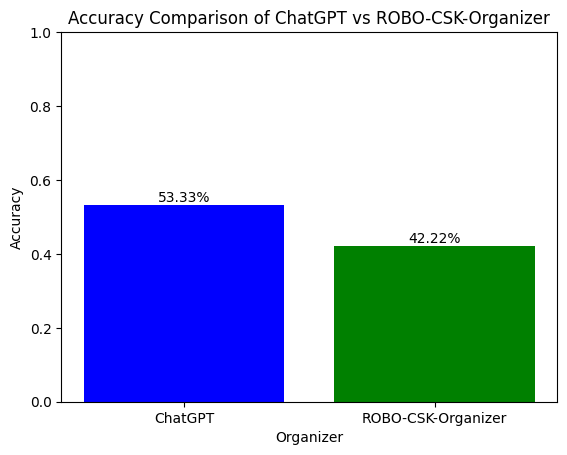

ChatGPT Accuracy: 53.33%
ConceptNet Accuracy: 42.22%


In [7]:
import matplotlib.pyplot as plt

chat_gpt_matches = sum(results_df['chat_gpt_context'] == results_df['ground_truth_context'])
conceptnet_matches = sum(results_df['conceptnet_context'] == results_df['ground_truth_context'])

chat_gpt_accuracy = chat_gpt_matches / len(results_df)
conceptnet_accuracy = conceptnet_matches / len(results_df)

# Visualize the accuracies
organizers = ['ChatGPT', 'ROBO-CSK-Organizer']
accuracies = [chat_gpt_accuracy, conceptnet_accuracy]

# Create the bar chart
bars = plt.bar(organizers, accuracies, color=['blue', 'green'])

# Annotate each bar with the accuracy percentage
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval*100:.2f}%', va='bottom', ha='center')

plt.xlabel('Organizer')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of ChatGPT vs ROBO-CSK-Organizer')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 (or 0% to 100%)
plt.show()


# Print the accuracies
print(f"ChatGPT Accuracy: {chat_gpt_accuracy * 100:.2f}%")
print(f"ConceptNet Accuracy: {conceptnet_accuracy * 100:.2f}%")


# Comparing Chat GPT and Conceptnet for Consistency

In [84]:
# Sort ambiguity_df by 'ambiguity_diff' and get the top 10
top_ambiguity_df = ambiguity_df.sort_values(by='ambiguity_diff').head(10)

print(top_ambiguity_df)


        object     context1  avg_similarity_context1      context2  \
34  calculator       office                 0.116988       bedroom   
39         box      kitchen                 0.229319  laundry_room   
21        dice  dining_room                 0.075184  laundry_room   
29        belt      kitchen                 0.091876       bedroom   
12     pretzel       garden                 0.098007      bathroom   
22  teddy_bear     playroom                 0.158204      bathroom   
42      flower  dining_room                 0.156286  laundry_room   
24        bowl       garden                 0.183661      bathroom   
13     popcorn  dining_room                 0.162669      bathroom   
7         wine      bedroom                 0.119755      bathroom   

    avg_similarity_context2  ambiguity_diff  
34                 0.116983        0.000006  
39                 0.229263        0.000056  
21                 0.075263        0.000078  
29                 0.091961        0.000085  

In [109]:
# Define your object lists and context groups
objects = {
    "Fruits": ['apple', 'orange', 'lemon', 'banana'],
    "Beverages": ['bottle', 'beer', 'juice', 'wine'],
    "Vegetables": ['carrot', 'bell_pepper', 'cucumber', 'broccoli' ],
    "Snacks": ['pretzel', 'popcorn', 'muffin', 'chocolate'],
    "Office Supplies": ['pen', 'adhesive_tape', 'stapler', 'scissors'],
    "Toys": ['ball', 'dice', 'teddy_bear', 'toy' ],
    "Kitchenware": ['bowl', 'knife', 'spoon', 'mug'],
    "Clothing": ['glove', 'belt', 'sock', 'tie'],
    "Personal Items": ['computer_mouse', 'coin', 'calculator', 'mobile_phone', 'remote_control', 'toothpaste', 'aerosol_can'],
    "Miscellaneous": ['box', 'boot', 'towel', 'flower', 'candle', 'bell']
}


culinary_locations = ["kitchen", "garden", "pantry", 'dining_room']


In [115]:
# Object based consistency tests

num_trials = 10  # Number of times to repeat the query for each object

consistency_results = []
# Define context groups for specific categories
context_groups = {
    "Personal Items": culinary_locations,
    "Clothing": culinary_locations,
    "Office Supplies": culinary_locations,
    "Toys": culinary_locations
}

# Iterate through the specified categories only
for category, obj_list in objects.items():
    if category in context_groups:
        for object_name in obj_list:
            contexts = context_groups[category]

            chat_gpt_responses = []
            conceptnet_responses = []

            for _ in range(num_trials):
                # Query each system with the specified contexts for this object
                chat_gpt_response = get_chat_gpt_context(object_name, contexts)
                conceptnet_response = get_conceptnet_context(object_name, contexts)[0]
                
                chat_gpt_responses.append(chat_gpt_response)
                conceptnet_responses.append(conceptnet_response)

            # Determine the most frequently chosen context and its count for ChatGPT
            most_common_chat_gpt_context = max(set(chat_gpt_responses), key=chat_gpt_responses.count)
            chat_gpt_context_count = chat_gpt_responses.count(most_common_chat_gpt_context)
            chat_gpt_consistency = chat_gpt_context_count / num_trials

            # Determine the most frequently chosen context and its count for ConceptNet
            most_common_conceptnet_context = max(set(conceptnet_responses), key=conceptnet_responses.count)
            conceptnet_context_count = conceptnet_responses.count(most_common_conceptnet_context)
            conceptnet_consistency = conceptnet_context_count / num_trials


            # Append the results with this additional information
            consistency_results.append({
                'object': object_name,
                'context1': contexts[0],
                'context2': contexts[1],
                'context3': contexts[2],
                'context4': contexts[3],
                'chat_gpt_consistency': chat_gpt_consistency,
                'chat_gpt_most_chosen_context': most_common_chat_gpt_context,
                'chat_gpt_context_count': chat_gpt_context_count,
                'conceptnet_consistency': conceptnet_consistency,
                'conceptnet_most_chosen_context': most_common_conceptnet_context,
                'conceptnet_context_count': conceptnet_context_count
            })

# Convert to DataFrame for further analysis
consistency_df = pd.DataFrame(consistency_results)


system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'pen' most likely associated with: kitchen, garden, pantry, dining_room? Please specify only the context as a response.
Execution time: 0.8693 seconds
The most relevant context for pen is dining_room.
Desired Contexts: ['kitchen', 'garden', 'pantry', 'dining_room']
Execution time for the robo-csk implementation: 0.0069 seconds
The most relevant context for pen is kitchen.
Path: kitchen (AtLocation) <- table (AtLocation) <- pen
Average_Weight: 3.15
Degree of Separation: 2
system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'pen' most likely associated with: kitchen, garden, pantry, dining_room? Please specify only the context as a response.
Execution time: 0.8077 seconds
The most relevant context for pen is dining_room.
Desired Contexts: ['kitchen', 'garden', 'pantry', 'dining_room']
Execution time for the robo-csk implementation: 0.0073 seconds
The m

In [86]:
# Ambiguity based consistency tests.

num_trials = 10  # Number of times to repeat the query for each object

consistency_results = []
for index, row in top_ambiguity_df.iterrows():
    object_name = row['object']
    contexts = [row['context1'], row['context2']]

    chat_gpt_responses = []
    conceptnet_responses = []

    for _ in range(num_trials):
        # Query each system with the most ambiguous contexts for this object
        chat_gpt_response = get_chat_gpt_context(object_name, contexts)
        conceptnet_response = get_conceptnet_context(object_name, contexts)[0]  # Assuming [0] is the context
        
        chat_gpt_responses.append(chat_gpt_response)
        conceptnet_responses.append(conceptnet_response)

    # Determine the most frequently chosen context and its count for ChatGPT
    most_common_chat_gpt_context = max(set(chat_gpt_responses), key=chat_gpt_responses.count)
    chat_gpt_context_count = chat_gpt_responses.count(most_common_chat_gpt_context)
    chat_gpt_consistency = chat_gpt_context_count / num_trials

    # Determine the most frequently chosen context and its count for ConceptNet
    most_common_conceptnet_context = max(set(conceptnet_responses), key=conceptnet_responses.count)
    conceptnet_context_count = conceptnet_responses.count(most_common_conceptnet_context)
    conceptnet_consistency = conceptnet_context_count / num_trials


    # Append the results with this additional information
    consistency_results.append({
        'object': object_name,
        'context1': contexts[0],
        'context2': contexts[1],
        'chat_gpt_consistency': chat_gpt_consistency,
        'chat_gpt_most_chosen_context': most_common_chat_gpt_context,
        'chat_gpt_context_count': chat_gpt_context_count,
        'conceptnet_consistency': conceptnet_consistency,
        'conceptnet_most_chosen_context': most_common_conceptnet_context,
        'conceptnet_context_count': conceptnet_context_count
    })

# Convert to DataFrame for further analysis
consistency_df = pd.DataFrame(consistency_results)


system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'calculator' most likely associated with: office, bedroom? Please specify only the context as a response.
Execution time for the chatgpt implementation: 0.5560 seconds
The most relevant context for calculator is office.
Desired Contexts: ['office', 'bedroom']
Execution time for the robo-csk implementation: 0.0048 seconds
The most relevant context for calculator is office.
Path: office (AtLocation) <- calculator
Average_Weight: 2.00
Degree of Separation: 1
system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'calculator' most likely associated with: office, bedroom? Please specify only the context as a response.
Execution time for the chatgpt implementation: 0.4211 seconds
The most relevant context for calculator is office.
Desired Contexts: ['office', 'bedroom']
Execution time for the robo-csk implementation: 0.0054 seconds
The most relevant context f

In [143]:
# Save the DataFrame to a CSV file
consistency_df.to_csv('consistency_results.csv', index=False)


In [8]:
import pandas as pd

# Read the data from the CSV file back into the consistency_df DataFrame
consistency_df = pd.read_csv('consistency_results.csv')


In [95]:
# Test Run

# Sample data to simulate responses
sample_responses = {
    "apple": {
        "chat_gpt_responses": ["kitchen", "kitchen", "pantry", "kitchen", "pantry", "kitchen", "kitchen", "pantry", "kitchen", "pantry"],
        "conceptnet_responses": ["kitchen", "pantry", "kitchen", "pantry", "pantry", "pantry", "pantry", "kitchen", "kitchen", "pantry"]
    },
    "orange": {
        "chat_gpt_responses": ["garden", "garden", "garden", "pantry", "garden", "garden", "pantry", "garden", "garden", "garden"],
        "conceptnet_responses": ["pantry", "garden", "pantry", "pantry", "garden", "pantry", "pantry", "pantry", "garden", "pantry"]
    }
}

num_trials = 10

consistency_results = []

for object_name, responses in sample_responses.items():
    chat_gpt_responses = responses["chat_gpt_responses"]
    conceptnet_responses = responses["conceptnet_responses"]

    # Determine the most frequently chosen context and its count for ChatGPT
    most_common_chat_gpt_context = max(set(chat_gpt_responses), key=chat_gpt_responses.count)
    chat_gpt_context_count = chat_gpt_responses.count(most_common_chat_gpt_context)
    chat_gpt_consistency = chat_gpt_context_count / num_trials

    # Determine the most frequently chosen context and its count for ConceptNet
    most_common_conceptnet_context = max(set(conceptnet_responses), key=conceptnet_responses.count)
    conceptnet_context_count = conceptnet_responses.count(most_common_conceptnet_context)
    conceptnet_consistency = conceptnet_context_count / num_trials

    consistency_results.append({
        'object': object_name,
        'chat_gpt_consistency': chat_gpt_consistency,
        'chat_gpt_most_chosen_context': most_common_chat_gpt_context,
        'chat_gpt_context_count': chat_gpt_context_count,
        'conceptnet_consistency': conceptnet_consistency,
        'conceptnet_most_chosen_context': most_common_conceptnet_context,
        'conceptnet_context_count': conceptnet_context_count
    })

# Convert to DataFrame for further analysis
consistency_df = pd.DataFrame(consistency_results)


In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set default font sizes
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

# Rest of your plotting code remains the same


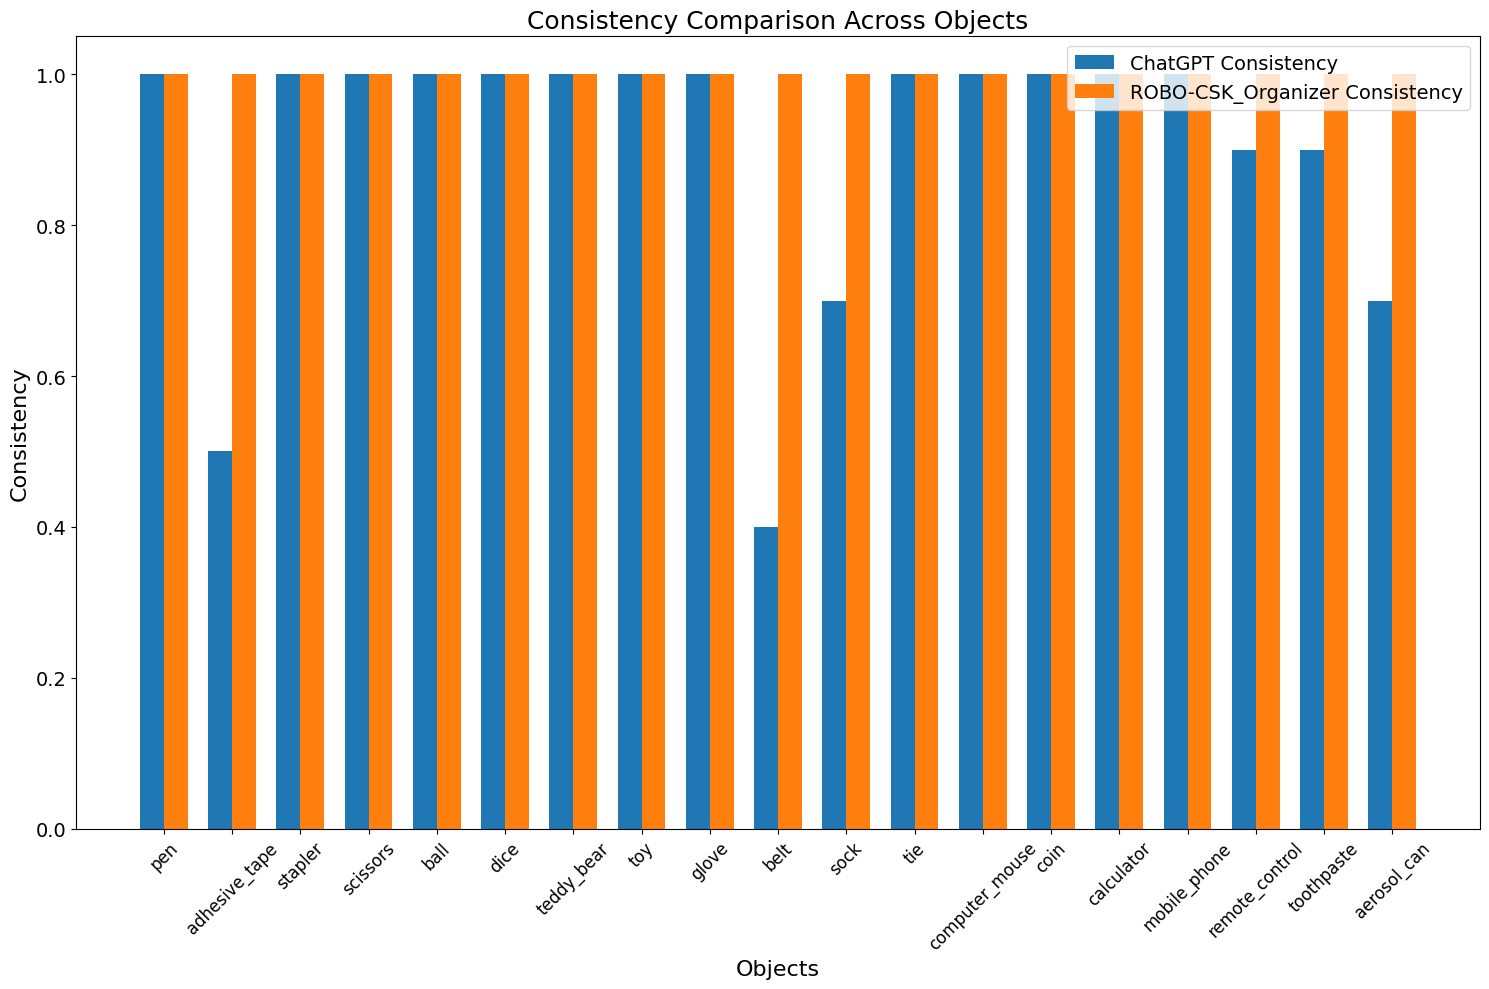

In [10]:
import matplotlib.pyplot as plt

# Setting up the plot
plt.figure(figsize=(15, 10))

# Number of objects
n_objects = len(consistency_df)

# Creating bar positions
bar_width = 0.35
index = range(n_objects)

# Plotting ChatGPT consistency
plt.bar(index, consistency_df['chat_gpt_consistency'], bar_width, label='ChatGPT Consistency')

# Plotting ConceptNet consistency
plt.bar([i + bar_width for i in index], consistency_df['conceptnet_consistency'], bar_width, label='ROBO-CSK_Organizer Consistency')

# Adding labels, title, and legend
plt.xlabel('Objects')
plt.ylabel('Consistency')
plt.title('Consistency Comparison Across Objects')
plt.xticks([i + bar_width / 2 for i in index], consistency_df['object'], rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


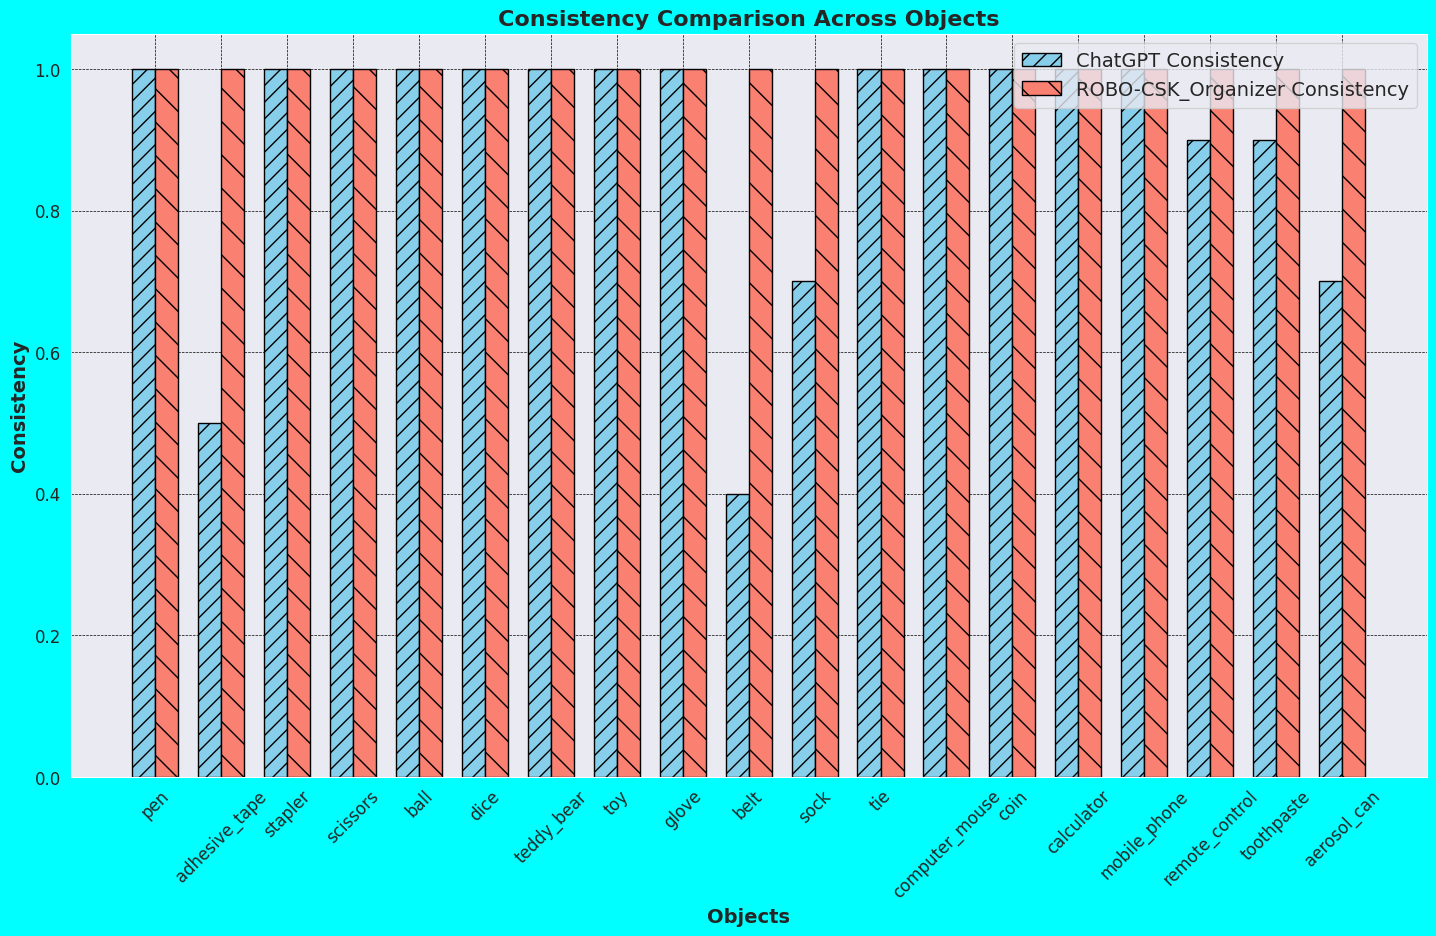

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Improve the aesthetics using seaborn
sns.set_style("darkgrid")

# Setting up the plot with a fancier background
plt.figure(figsize=(15, 10), facecolor='black')

# Number of objects
n_objects = len(consistency_df)

# Creating bar positions
bar_width = 0.35
index = np.arange(n_objects)

# Plotting ChatGPT consistency with a new color and pattern
plt.bar(index, consistency_df['chat_gpt_consistency'], bar_width, label='ChatGPT Consistency',
        color='skyblue', edgecolor='black', hatch='//')

# Plotting ConceptNet consistency with a new color and pattern
plt.bar([i + bar_width for i in index], consistency_df['conceptnet_consistency'], bar_width,
        label='ROBO-CSK_Organizer Consistency', color='salmon', edgecolor='black', hatch='\\')

# Adding labels, title, and legend with enhanced fonts
plt.xlabel('Objects', fontsize=14, fontweight='bold')
plt.ylabel('Consistency', fontsize=14, fontweight='bold')
plt.title('Consistency Comparison Across Objects', fontsize=16, fontweight='bold')
plt.xticks([i + bar_width / 2 for i in index], consistency_df['object'], rotation=45, fontsize=12)

plt.legend()

# Customize the ticks for both axes
plt.tick_params(axis='both', which='major', labelsize=12)

# Adding a grid for better readability
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='black')

# Tight layout with a fancier background
plt.tight_layout(pad=3)

# Change figure background color
plt.gcf().set_facecolor('cyan')

# Show the plot
plt.show()


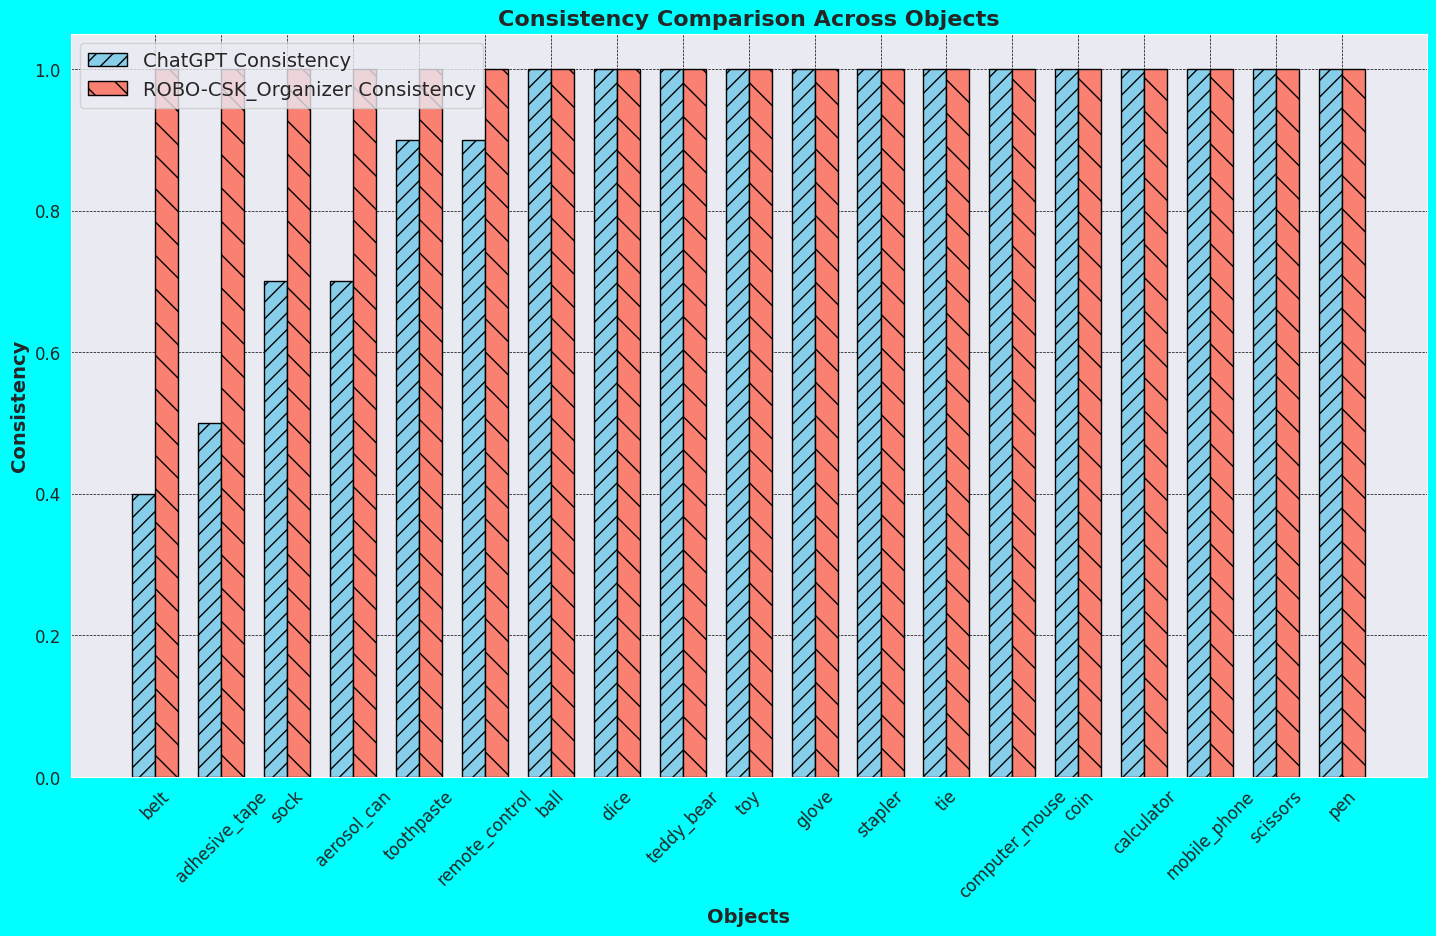

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd  # Assuming you are using pandas DataFrame for consistency_df

# Assuming consistency_df is a pandas DataFrame
# Sort the DataFrame by 'chat_gpt_consistency'
consistency_df = consistency_df.sort_values(by='chat_gpt_consistency', ascending=True)

# Now that the DataFrame is sorted, proceed with the plotting

# Improve the aesthetics using seaborn
sns.set_style("darkgrid")

# Setting up the plot with a fancier background
plt.figure(figsize=(15, 10), facecolor='black')

# Number of objects (after sorting)
n_objects = len(consistency_df)

# Creating bar positions
bar_width = 0.35
index = np.arange(n_objects)

# Plotting ChatGPT consistency with a new color and pattern
plt.bar(index, consistency_df['chat_gpt_consistency'], bar_width, label='ChatGPT Consistency',
        color='skyblue', edgecolor='black', hatch='//')

# Plotting ConceptNet consistency with a new color and pattern
plt.bar([i + bar_width for i in index], consistency_df['conceptnet_consistency'], bar_width,
        label='ROBO-CSK_Organizer Consistency', color='salmon', edgecolor='black', hatch='\\')

# Adding labels, title, and legend with enhanced fonts
plt.xlabel('Objects', fontsize=14, fontweight='bold')
plt.ylabel('Consistency', fontsize=14, fontweight='bold')
plt.title('Consistency Comparison Across Objects', fontsize=16, fontweight='bold')

# Update xticks after sorting
plt.xticks([i + bar_width / 2 for i in index], consistency_df['object'], rotation=45, fontsize=12)

plt.legend()

# Customize the ticks for both axes
plt.tick_params(axis='both', which='major', labelsize=12)

# Adding a grid for better readability
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='black')

# Tight layout with a fancier background
plt.tight_layout(pad=3)

# Change figure background color
plt.gcf().set_facecolor('cyan')

# Show the plot
plt.show()


# Code Implementation for Baseline Task Test for adaptability

In [118]:
num_trials = 10  # Number of times to repeat the query for each object
object_name = 'apple'
contexts = ["kitchen", "living_room", "bedroom", "bathroom"]

baseline_results = []

for _ in range(num_trials):
    chat_gpt_response = get_chat_gpt_context(object_name, contexts)
    conceptnet_response, conceptnet_path = get_conceptnet_context(object_name, contexts)[0]  # Assuming the first element is the context

    baseline_results.append({
        'object': object_name,
        'chat_gpt_response': chat_gpt_response,
        'conceptnet_response': conceptnet_response,
        'conceptnet_path': conceptnet_path
    })

baseline_df = pd.DataFrame(baseline_results)


system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: kitchen, living_room, bedroom, bathroom? Please specify only the context as a response.
Execution time: 1.2098 seconds
The most relevant context for apple is kitchen.
Desired Contexts: ['kitchen', 'living_room', 'bedroom', 'bathroom']
Execution time for the robo-csk implementation: 0.0132 seconds
The most relevant context for apple is kitchen.
Path: kitchen (AtLocation) <- food (RelatedTo) -> apple
Average_Weight: 4.76
Degree of Separation: 2
system: You are a helpful assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: kitchen, living_room, bedroom, bathroom? Please specify only the context as a response.
Execution time: 0.6139 seconds
The most relevant context for apple is kitchen.
Desired Contexts: ['kitchen', 'living_room', 'bedroom', 'bathroom']
Execution time for the robo-csk implementation: 0.0118

# Determine the most preferred context

In [122]:
import pandas as pd
from collections import Counter



chat_gpt_most_common = Counter(baseline_df['chat_gpt_response']).most_common(1)[0][0]
conceptnet_most_common = Counter(baseline_df['conceptnet_response']).most_common(1)[0][0]

# Assuming we take the most common from ChatGPT for the focus test
most_preferred_context = chat_gpt_most_common

# Code Implementation for Adaptability Task Test

In [125]:
adaptability_results = []

# Define the number of trials for each focus context
num_trials_per_focus = 10

# For each of the other three contexts
for focus_context in set(contexts) - {most_preferred_context}:
    for _ in range(num_trials_per_focus):
        chat_gpt_response = get_chat_gpt_context(object_name, contexts, focus_contexts=[focus_context])
        conceptnet_response, conceptnet_path = get_conceptnet_context(object_name, contexts, focus_contexts=[focus_context])

        adaptability_results.append({
            'object': object_name,
            'focus_context': focus_context,
            'chat_gpt_response': chat_gpt_response,
            'conceptnet_response': conceptnet_response,
            'conceptnet_path': conceptnet_path
        })

adaptability_df = pd.DataFrame(adaptability_results)


system: You are a helpful bathroom assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: kitchen, living_room, bedroom, bathroom? Please specify only the context as a response.
Execution time: 0.6569 seconds
The most relevant context for apple is kitchen.
Desired Contexts: ['kitchen', 'living_room', 'bedroom', 'bathroom']
Execution time for the robo-csk implementation: 0.0193 seconds
The most relevant context for apple is kitchen.
Path: kitchen (AtLocation) <- food (RelatedTo) -> apple
Average_Weight: 4.76
Degree of Separation: 2
system: You are a helpful bathroom assistant robot.
user: Which of the following contexts is the object 'apple' most likely associated with: kitchen, living_room, bedroom, bathroom? Please specify only the context as a response.
Execution time: 0.8006 seconds
The most relevant context for apple is kitchen.
Desired Contexts: ['kitchen', 'living_room', 'bedroom', 'bathroom']
Execution time for the robo-csk impl

# save basefile and adaptability as csv files

In [133]:
# Saving adaptability_df as a CSV file
adaptability_df.to_csv('adaptability_results.csv', index=False)

# Saving baseline_df as a CSV file
baseline_df.to_csv('baseline_results.csv', index=False)


# Load DF from their relevant CSV files

In [52]:
import pandas as pd

# Reading the data from the 'adaptability_results.csv' file into the adaptability_df DataFrame
adaptability_df = pd.read_csv('adaptability_results.csv')

# Reading the data from the 'baseline_results.csv' file into the baseline_df DataFrame
baseline_df = pd.read_csv('baseline_results.csv')


# Example of how to visualize the data basiline and adaptability 

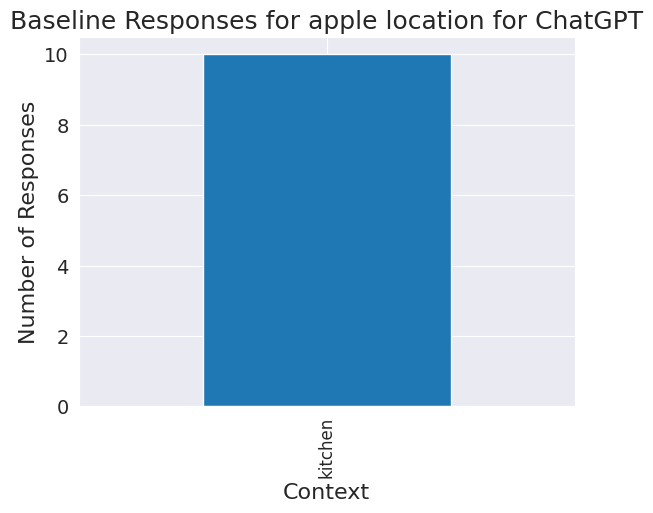

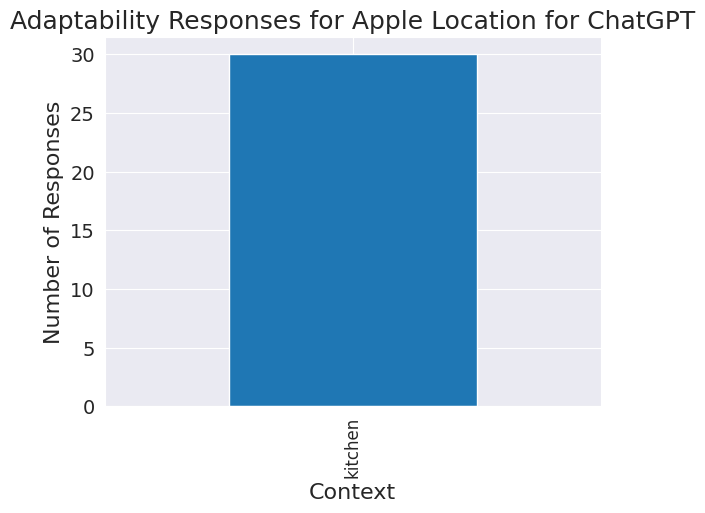

In [49]:
import matplotlib.pyplot as plt

# Example of how to visualize the data
def visualize_responses(df, title, response_column):
    response_counts = df[response_column].value_counts()
    response_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Context')
    plt.ylabel('Number of Responses')
    plt.show()

# Visualize baseline responses
visualize_responses(baseline_df, 'Baseline Responses for apple location for ChatGPT', 'chat_gpt_response')

# Visualize adaptability responses
visualize_responses(adaptability_df, 'Adaptability Responses for Apple Location for ChatGPT', 'chat_gpt_response')


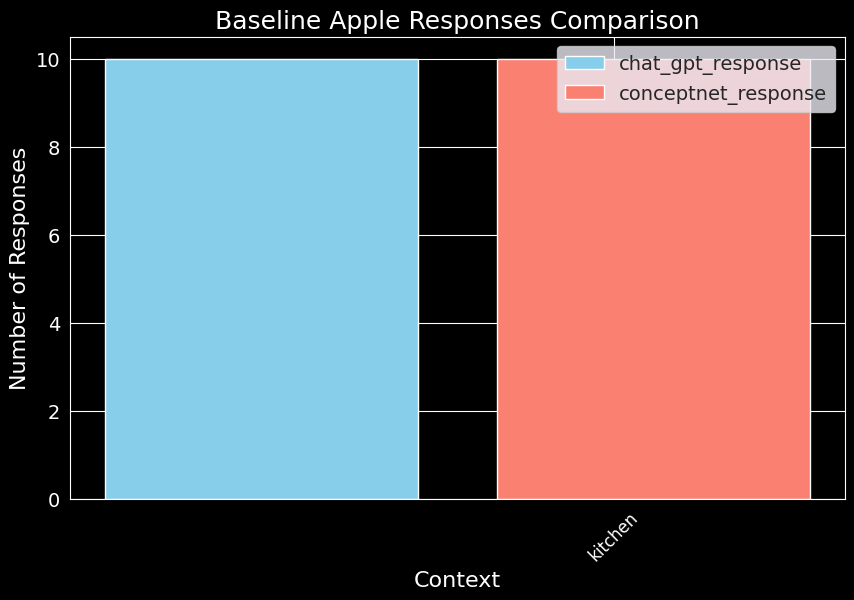

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_responses(df, title, response_columns, colors):
    # Create a figure with a black background
    plt.figure(figsize=(10, 6))
    plt.gca().set_facecolor('black')
    plt.gcf().set_facecolor('black')
    
    # Determine the width of the bars and the space between them
    bar_width = 0.2  # Make bars narrower
    space_between_bars = 0.05  # Space between individual bars
    space_between_groups = 0.1  # Additional space between groups to avoid touching
    
    # Plot bars for each response column
    for idx, (response_column, color) in enumerate(zip(response_columns, colors)):
        response_counts = df[response_column].value_counts()
        # Calculate bar positions with added space between groups and bars
        bar_positions = np.arange(len(response_counts)) * (len(response_columns) * (bar_width + space_between_bars) + space_between_groups) + idx * (bar_width + space_between_bars)
        plt.bar(bar_positions, response_counts, width=bar_width, label=response_column, color=color)
    
    # Adjusting the ticks to align with the center of the groups
    group_centers = np.arange(len(response_counts)) * (len(response_columns) * (bar_width + space_between_bars) + space_between_groups) + (bar_width + space_between_bars) * (len(response_columns) / 2) - space_between_bars / 2
    plt.xticks(ticks=group_centers, labels=response_counts.index, rotation=45, color='white')
    
    # Other settings remain unchanged
    plt.title(title, color='white')
    plt.xlabel('Context', color='white')
    plt.ylabel('Number of Responses', color='white')
    plt.yticks(color='white')
    plt.legend()
    
    # Show the plot
    plt.show()

visualize_responses(baseline_df, 'Baseline Apple Responses Comparison', ['chat_gpt_response', 'conceptnet_response'], ['skyblue', 'salmon'])



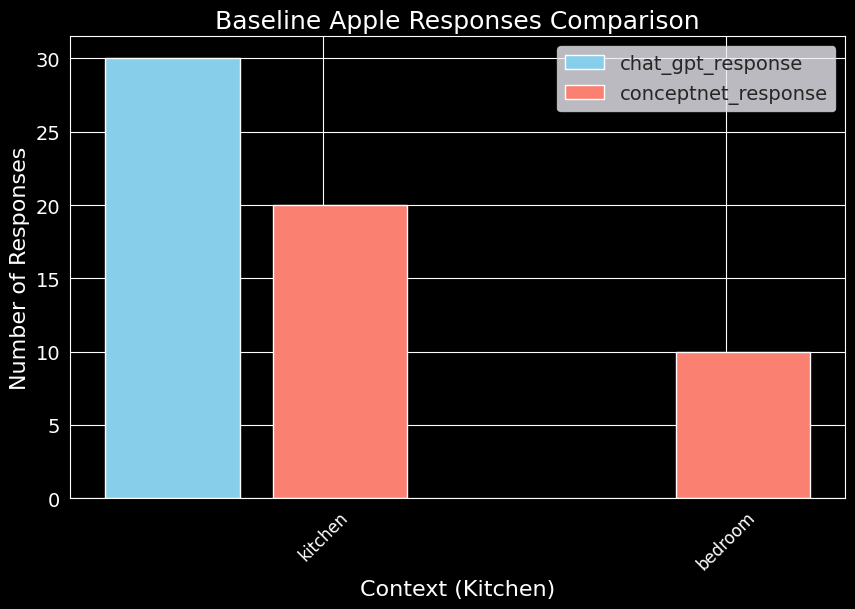

In [54]:
visualize_responses(adaptability_df, 'Baseline Apple Responses Comparison', ['chat_gpt_response', 'conceptnet_response'], ['skyblue', 'salmon'])

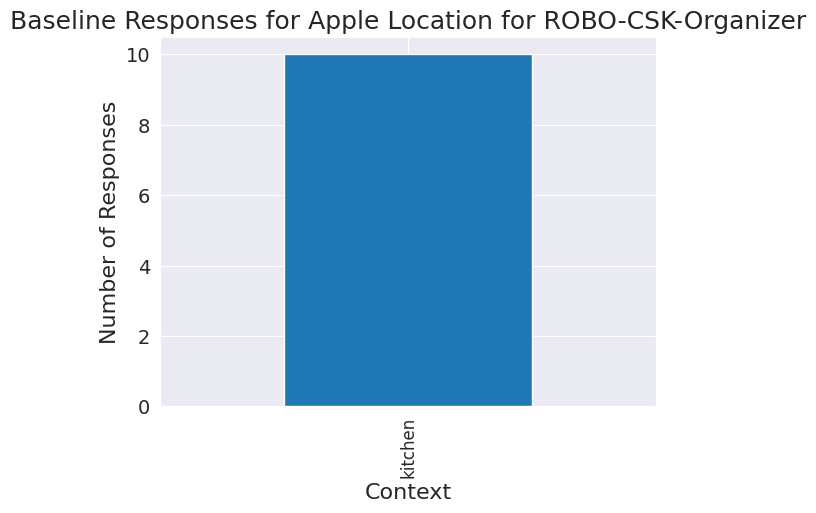

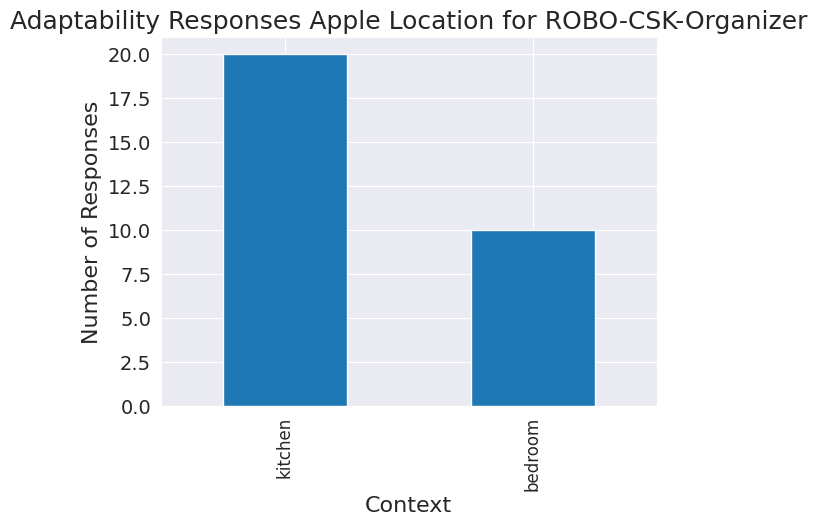

In [50]:
import matplotlib.pyplot as plt

# Function to visualize the data
def visualize_responses(df, title, response_column):
    response_counts = df[response_column].value_counts()
    response_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Context')
    plt.ylabel('Number of Responses')
    plt.show()

# Visualize baseline responses for ConceptNet
visualize_responses(baseline_df, 'Baseline Responses for Apple Location for ROBO-CSK-Organizer', 'conceptnet_response')

# Visualize adaptability responses for ConceptNet
visualize_responses(adaptability_df, 'Adaptability Responses Apple Location for ROBO-CSK-Organizer', 'conceptnet_response')


# Function to visualize the data and save as an image file

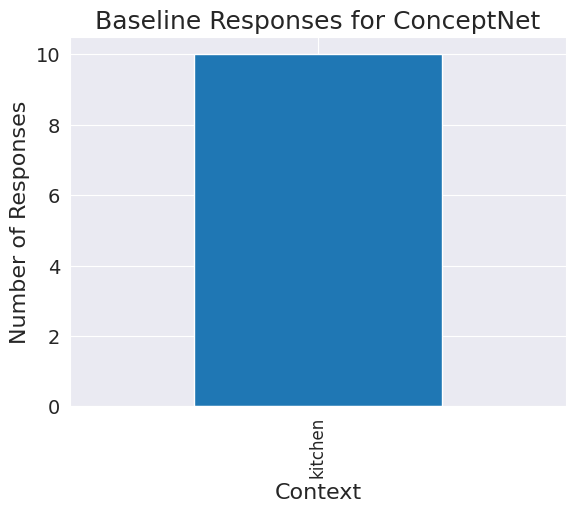

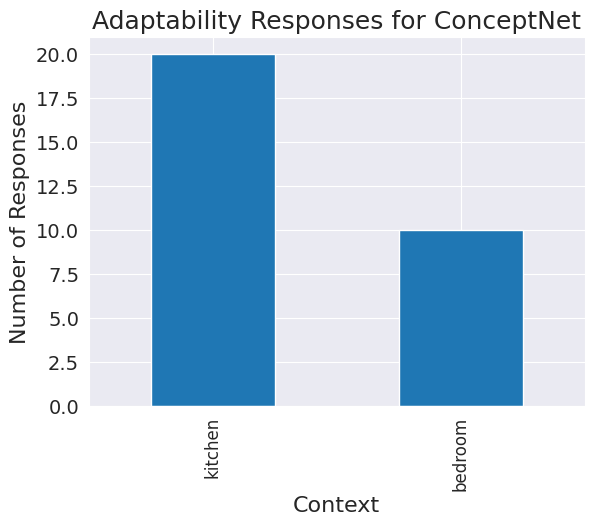

In [51]:
import matplotlib.pyplot as plt

# Function to visualize the data and save as an image file
def visualize_responses(df, title, response_column, file_name):
    response_counts = df[response_column].value_counts()
    response_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Context')
    plt.ylabel('Number of Responses')
    plt.savefig(file_name)  # Save the plot as a file
    plt.show()

# Visualize and save baseline responses for ConceptNet
visualize_responses(baseline_df, 'Baseline Responses for ConceptNet', 'conceptnet_response', 'baseline_conceptnet_responses.png')

# Visualize and save adaptability responses for ConceptNet
visualize_responses(adaptability_df, 'Adaptability Responses for ConceptNet', 'conceptnet_response', 'adaptability_conceptnet_responses.png')


# Delete the Models and Clear Variables

In [8]:
# Delete the model objects
del bert_model
del word2vec_model
del glove_model

# Clear any other large variables
del tokenizer


NameError: name 'bert_model' is not defined

# Manually trigger garbage collection

In [4]:
import gc

gc.collect()

0